# Setup

In [ ]:
!pip install --upgrade keras_cv tensorflow
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found 

In [ ]:
import keras
from keras_cv.layers import DropPath
from keras import ops
from keras import layers

import tensorflow as tf  # only for dataloader
import tensorflow_datasets as tfds  # for flower dataset

from skimage.data import chelsea
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

class SqueezeAndExcitation(layers.Layer):
    """Squeeze and excitation block.

    Args:
        output_dim: output features dimension, if `None` use same dim as input.
        expansion: expansion ratio.
    """

    def __init__(self, output_dim=None, expansion=0.25, **kwargs):
        super().__init__(**kwargs)
        self.expansion = expansion
        self.output_dim = output_dim

    def build(self, input_shape):
        inp = input_shape[-1]
        self.output_dim = self.output_dim or inp
        self.avg_pool = layers.GlobalAvgPool2D(keepdims=True, name="avg_pool")
        self.fc = [
            layers.Dense(int(inp * self.expansion), use_bias=False, name="fc_0"),
            layers.Activation("gelu", name="fc_1"),
            layers.Dense(self.output_dim, use_bias=False, name="fc_2"),
            layers.Activation("sigmoid", name="fc_3"),
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = self.avg_pool(inputs)
        for layer in self.fc:
            x = layer(x)
        return x * inputs


class ReduceSize(layers.Layer):
    """Down-sampling block.

    Args:
        keepdims: if False spatial dim is reduced and channel dim is increased
    """

    def __init__(self, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        dim_out = embed_dim if self.keepdims else 2 * embed_dim
        self.pad1 = layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            layers.DepthwiseConv2D(
                kernel_size=3, strides=1, padding="valid", use_bias=False, name="conv_0"
            ),
            layers.Activation("gelu", name="conv_1"),
            SqueezeAndExcitation(name="conv_2"),
            layers.Conv2D(
                embed_dim,
                kernel_size=1,
                strides=1,
                padding="valid",
                use_bias=False,
                name="conv_3",
            ),
        ]
        self.reduction = layers.Conv2D(
            dim_out,
            kernel_size=3,
            strides=2,
            padding="valid",
            use_bias=False,
            name="reduction",
        )
        self.norm1 = layers.LayerNormalization(
            -1, 1e-05, name="norm1"
        )  # eps like PyTorch
        self.norm2 = layers.LayerNormalization(-1, 1e-05, name="norm2")

    def call(self, inputs, **kwargs):
        x = self.norm1(inputs)
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr
        x = self.pad2(x)
        x = self.reduction(x)
        x = self.norm2(x)
        return x


class MLP(layers.Layer):
    """Multi-Layer Perceptron (MLP) block.

    Args:
        hidden_features: hidden features dimension.
        out_features: output features dimension.
        activation: activation function.
        dropout: dropout rate.
    """

    def __init__(
        self,
        hidden_features=None,
        out_features=None,
        activation="gelu",
        dropout=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.activation = activation
        self.dropout = dropout

    def build(self, input_shape):
        self.in_features = input_shape[-1]
        self.hidden_features = self.hidden_features or self.in_features
        self.out_features = self.out_features or self.in_features
        self.fc1 = layers.Dense(self.hidden_features, name="fc1")
        self.act = layers.Activation(self.activation, name="act")
        self.fc2 = layers.Dense(self.out_features, name="fc2")
        self.drop1 = layers.Dropout(self.dropout, name="drop1")
        self.drop2 = layers.Dropout(self.dropout, name="drop2")

    def call(self, inputs, **kwargs):
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


In [ ]:

class PatchEmbed(layers.Layer):
    """Patch embedding block.

    Args:
        embed_dim: feature size dimension.
    """

    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.pad = layers.ZeroPadding2D(1, name="pad")
        self.proj = layers.Conv2D(self.embed_dim, 3, 2, name="proj")
        self.conv_down = ReduceSize(keepdims=True, name="conv_down")

    def call(self, inputs, **kwargs):
        x = self.pad(inputs)
        x = self.proj(x)
        x = self.conv_down(x)
        return x


In [ ]:

class FeatureExtraction(layers.Layer):
    """Feature extraction block.

    Args:
        keepdims: bool argument for maintaining the resolution.
    """

    def __init__(self, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        self.pad1 = layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            layers.DepthwiseConv2D(3, 1, use_bias=False, name="conv_0"),
            layers.Activation("gelu", name="conv_1"),
            SqueezeAndExcitation(name="conv_2"),
            layers.Conv2D(embed_dim, 1, 1, use_bias=False, name="conv_3"),
        ]
        if not self.keepdims:
            self.pool = layers.MaxPool2D(3, 2, name="pool")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr
        if not self.keepdims:
            x = self.pool(self.pad2(x))
        return x


class GlobalQueryGenerator(layers.Layer):
    """Global query generator.

    Args:
        keepdims: to keep the dimension of FeatureExtraction layer.
        For instance, repeating log(56/7) = 3 blocks, with input
        window dimension 56 and output window dimension 7 at down-sampling
        ratio 2. Please check Fig.5 of GC ViT paper for details.
    """

    def __init__(self, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims

    def build(self, input_shape):
        self.to_q_global = [
            FeatureExtraction(keepdims, name=f"to_q_global_{i}")
            for i, keepdims in enumerate(self.keepdims)
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        for layer in self.to_q_global:
            x = layer(x)
        return x


In [ ]:
class penalty_matrix(layers.Layer):
  def __init__(self, keepdims=False, **kwargs):
    super().__init__(**kwargs)
    self.keepdims = keepdims
    self.distances=None
    self.extract_patches=None
    self.penalty=0



  def extract_patches(self, image, patch_size):
    patches = []
    h, w = image.shape
    ph, pw = patch_size

    for i in range(0, h-ph+1):
        for j in range(0, w-pw+1):
            patch = image[i:i+ph, j:j+pw]
            patches.append(patch)

    return np.array(patches)


  def pairwise_manhattan_distance(image1, image2, patch_size):
    # Extract patches from both images
    patches_image1 = self.extract_patches(image1, patch_size)
    patches_image2 = self.extract_patches(image2, patch_size)

    # Reshape patches into vectors
    vectors_image1 = patches_image1.reshape(len(patches_image1), -1)
    vectors_image2 = patches_image2.reshape(len(patches_image2), -1)

    # Compute Manhattan distance between all pairs of patches
    self.distances = np.zeros((len(patches_image1), len(patches_image2)))
    for i, patch1 in enumerate(vectors_image1):
        for j, patch2 in enumerate(vectors_image2):
            self.distances=self.distances[i, j] = np.sum(np.abs(patch1 - patch2))

    return self.distances

  def compute_penalty_matrix(patch1, patch2, all_distances,a ,b):
    distance = self.pairwise_manhattan_distance(patch1, patch2)
    max_distance = np.max(all_distances)
    self.penalty = (distance - max_distance/a) / ((distance - max_distance/a)**2 + b)**0.5
    return self.penalty

In [ ]:

class WindowAttention(layers.Layer):
    """Local window attention.

    This implementation was proposed by
    [Liu et al., 2021](https://arxiv.org/abs/2103.14030) in SwinTransformer.

    Args:
        window_size: window size.
        num_heads: number of attention head.
        global_query: if the input contains global_query
        qkv_bias: bool argument for query, key, value learnable bias.
        qk_scale: bool argument to scaling query, key.
        attention_dropout: attention dropout rate.
        projection_dropout: output dropout rate.
    """

    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        qkv_bias=True,
        qk_scale=None,
        attention_dropout=0.0,
        projection_dropout=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        window_size = (window_size, window_size)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attention_dropout = attention_dropout
        self.projection_dropout = projection_dropout

    def build(self, input_shape):
        embed_dim = input_shape[0][-1]
        head_dim = embed_dim // self.num_heads
        self.scale = self.qk_scale or head_dim**-0.5
        self.qkv_size = 3 - int(self.global_query)
        self.qkv = layers.Dense(
            embed_dim * self.qkv_size, use_bias=self.qkv_bias, name="qkv"
        )
        self.relative_position_bias_table = self.add_weight(
            name="relative_position_bias_table",
            shape=[
                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
                self.num_heads,
            ],
            initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            dtype=self.dtype,
        )
        self.attn_drop = layers.Dropout(self.attention_dropout, name="attn_drop")
        self.proj = layers.Dense(embed_dim, name="proj")
        self.proj_drop = layers.Dropout(self.projection_dropout, name="proj_drop")
        self.softmax = layers.Activation("softmax", name="softmax")
        super().build(input_shape)

    def get_relative_position_index(self):
        coords_h = ops.arange(self.window_size[0])
        coords_w = ops.arange(self.window_size[1])
        coords = ops.stack(ops.meshgrid(coords_h, coords_w, indexing="ij"), axis=0)
        coords_flatten = ops.reshape(coords, [2, -1])
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = ops.transpose(relative_coords, axes=[1, 2, 0])
        relative_coords_xx = relative_coords[:, :, 0] + self.window_size[0] - 1
        relative_coords_yy = relative_coords[:, :, 1] + self.window_size[1] - 1
        relative_coords_xx = relative_coords_xx * (2 * self.window_size[1] - 1)
        relative_position_index = relative_coords_xx + relative_coords_yy
        return relative_position_index

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
            B = ops.shape(q_global)[0]  # B, N, C
        else:
            inputs = inputs[0]
        B_, N, C = ops.shape(inputs)  # B*num_window, num_tokens, channels
        qkv = self.qkv(inputs)
        qkv = ops.reshape(
            qkv, [B_, N, self.qkv_size, self.num_heads, C // self.num_heads]
        )
        qkv = ops.transpose(qkv, [2, 0, 3, 1, 4])
        if self.global_query:
            k, v = ops.split(
                qkv, indices_or_sections=2, axis=0
            )  # for unknown shame num=None will throw error
            q_global = ops.repeat(
                q_global, repeats=B_ // B, axis=0
            )  # num_windows = B_//B => q_global same for all windows in a img
            q = ops.reshape(q_global, [B_, N, self.num_heads, C // self.num_heads])
            q = ops.transpose(q, axes=[0, 2, 1, 3])
        else:
            q, k, v = ops.split(qkv, indices_or_sections=3, axis=0)
            q = ops.squeeze(q, axis=0)

        k = ops.squeeze(k, axis=0)
        v = ops.squeeze(v, axis=0)

        q = q * self.scale
        attn = q @ ops.transpose(k, axes=[0, 1, 3, 2])
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            ops.reshape(self.get_relative_position_index(), [-1]),
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            [
                self.window_size[0] * self.window_size[1],
                self.window_size[0] * self.window_size[1],
                -1,
            ],
        )
        relative_position_bias = ops.transpose(relative_position_bias, axes=[2, 0, 1])
        attn = attn + relative_position_bias[None,]
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = ops.transpose((attn @ v), axes=[0, 2, 1, 3])
        x = ops.reshape(x, [B_, N, C])
        x = self.proj_drop(self.proj(x))
        return x


In [ ]:
class regularised_loss(penalty_matrix):
  def __init__(self, attn, x, dist, **kwargs):
    super().__init__(**kwargs)
    self.attn=attn
    self.x=x
    self.dist=dist
    self.penalty=penalty
    self.penalty_loss=0

  def att_penalty(self):
    for i in range(len(self.attn)):
      for j in range(len(self.attn[0])):
        self.penalty_loss += self.attn[i][j] * self.penalty[i][j]
    self.penalty_loss=max(self.penalty_loss, 0)
    return np.log(sum(self.penalty_loss))


In [ ]:

class Block(layers.Layer):
    """GCViT block.

    Args:
        window_size: window size.
        num_heads: number of attention head.
        global_query: apply global window attention
        mlp_ratio: MLP ratio.
        qkv_bias: bool argument for query, key, value learnable bias.
        qk_scale: bool argument to scaling query, key.
        drop: dropout rate.
        attention_dropout: attention dropout rate.
        path_drop: drop path rate.
        activation: activation function.
        layer_scale: layer scaling coefficient.
    """

    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        dropout=0.0,
        attention_dropout=0.0,
        path_drop=0.0,
        activation="gelu",
        layer_scale=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop
        self.activation = activation
        self.layer_scale = layer_scale

    def build(self, input_shape):
        B, H, W, C = input_shape[0]
        self.norm1 = layers.LayerNormalization(-1, 1e-05, name="norm1")
        self.attn = WindowAttention(
            window_size=self.window_size,
            num_heads=self.num_heads,
            global_query=self.global_query,
            qkv_bias=self.qkv_bias,
            qk_scale=self.qk_scale,
            attention_dropout=self.attention_dropout,
            projection_dropout=self.dropout,
            name="attn",
        )
        self.drop_path1 = DropPath(self.path_drop)
        self.drop_path2 = DropPath(self.path_drop)
        self.norm2 = layers.LayerNormalization(-1, 1e-05, name="norm2")
        self.mlp = MLP(
            hidden_features=int(C * self.mlp_ratio),
            dropout=self.dropout,
            activation=self.activation,
            name="mlp",
        )
        if self.layer_scale is not None:
            self.gamma1 = self.add_weight(
                name="gamma1",
                shape=[C],
                initializer=keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
            self.gamma2 = self.add_weight(
                name="gamma2",
                shape=[C],
                initializer=keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
        else:
            self.gamma1 = 1.0
            self.gamma2 = 1.0
        self.num_windows = int(H // self.window_size) * int(W // self.window_size)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
        else:
            inputs = inputs[0]
        B, H, W, C = ops.shape(inputs)
        x = self.norm1(inputs)
        # create windows and concat them in batch axis
        x = self.window_partition(x, self.window_size)  # (B_, win_h, win_w, C)
        # flatten patch
        x = ops.reshape(x, [-1, self.window_size * self.window_size, C])
        # attention
        if self.global_query:
            x = self.attn([x, q_global])
        else:
            x = self.attn([x])
        # reverse window partition
        x = self.window_reverse(x, self.window_size, H, W, C)
        # FFN
        x = inputs + self.drop_path1(x * self.gamma1)
        x = x + self.drop_path2(self.gamma2 * self.mlp(self.norm2(x)))
        return x

    def window_partition(self, x, window_size):
        """
        Args:
            x: (B, H, W, C)
            window_size: window size
        Returns:
            local window features (num_windows*B, window_size, window_size, C)
        """
        B, H, W, C = ops.shape(x)
        x = ops.reshape(
            x,
            [
                -1,
                H // window_size,
                window_size,
                W // window_size,
                window_size,
                C,
            ],
        )
        x = ops.transpose(x, axes=[0, 1, 3, 2, 4, 5])
        windows = ops.reshape(x, [-1, window_size, window_size, C])
        return windows

    def window_reverse(self, windows, window_size, H, W, C):
        """
        Args:
            windows: local window features (num_windows*B, window_size, window_size, C)
            window_size: Window size
            H: Height of image
            W: Width of image
            C: Channel of image
        Returns:
            x: (B, H, W, C)
        """
        x = ops.reshape(
            windows,
            [
                -1,
                H // window_size,
                W // window_size,
                window_size,
                window_size,
                C,
            ],
        )
        x = ops.transpose(x, axes=[0, 1, 3, 2, 4, 5])
        x = ops.reshape(x, [-1, H, W, C])
        return x


In [ ]:

class Level(layers.Layer):
    """GCViT level.

    Args:
        depth: number of layers in each stage.
        num_heads: number of heads in each stage.
        window_size: window size in each stage.
        keepdims: dims to keep in FeatureExtraction.
        downsample: bool argument for down-sampling.
        mlp_ratio: MLP ratio.
        qkv_bias: bool argument for query, key, value learnable bias.
        qk_scale: bool argument to scaling query, key.
        drop: dropout rate.
        attention_dropout: attention dropout rate.
        path_drop: drop path rate.
        layer_scale: layer scaling coefficient.
    """

    def __init__(
        self,
        depth,
        num_heads,
        window_size,
        keepdims,
        downsample=True,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        dropout=0.0,
        attention_dropout=0.0,
        path_drop=0.0,
        layer_scale=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size
        self.keepdims = keepdims
        self.downsample = downsample
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop
        self.layer_scale = layer_scale

    def build(self, input_shape):
        path_drop = (
            [self.path_drop] * self.depth
            if not isinstance(self.path_drop, list)
            else self.path_drop
        )
        self.blocks = [
            Block(
                window_size=self.window_size,
                num_heads=self.num_heads,
                global_query=bool(i % 2),
                mlp_ratio=self.mlp_ratio,
                qkv_bias=self.qkv_bias,
                qk_scale=self.qk_scale,
                dropout=self.dropout,
                attention_dropout=self.attention_dropout,
                path_drop=path_drop[i],
                layer_scale=self.layer_scale,
                name=f"blocks_{i}",
            )
            for i in range(self.depth)
        ]
        self.down = ReduceSize(keepdims=False, name="downsample")
        self.q_global_gen = GlobalQueryGenerator(self.keepdims, name="q_global_gen")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        q_global = self.q_global_gen(x)  # shape: (B, win_size, win_size, C)
        for i, blk in enumerate(self.blocks):
            if i % 2:
                x = blk([x, q_global])  # shape: (B, H, W, C)
            else:
                x = blk([x])  # shape: (B, H, W, C)
        if self.downsample:
            x = self.down(x)  # shape: (B, H//2, W//2, 2*C)
        return x


In [ ]:

class GCViT(keras.Model):
    """GCViT model.

    Args:
        window_size: window size in each stage.
        embed_dim: feature size dimension.
        depths: number of layers in each stage.
        num_heads: number of heads in each stage.
        drop_rate: dropout rate.
        mlp_ratio: MLP ratio.
        qkv_bias: bool argument for query, key, value learnable bias.
        qk_scale: bool argument to scaling query, key.
        attention_dropout: attention dropout rate.
        path_drop: drop path rate.
        layer_scale: layer scaling coefficient.
        num_classes: number of classes.
        head_activation: activation function for head.
    """

    def __init__(
        self,
        window_size,
        embed_dim,
        depths,
        num_heads,
        drop_rate=0.0,
        mlp_ratio=3.0,
        qkv_bias=True,
        qk_scale=None,
        attention_dropout=0.0,
        path_drop=0.1,
        layer_scale=None,
        num_classes=1000,
        head_activation="softmax",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.window_size = window_size
        self.embed_dim = embed_dim
        self.depths = depths
        self.num_heads = num_heads
        self.drop_rate = drop_rate
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop
        self.layer_scale = layer_scale
        self.num_classes = num_classes
        self.head_activation = head_activation

        self.patch_embed = PatchEmbed(embed_dim=embed_dim, name="patch_embed")
        self.pos_drop = layers.Dropout(drop_rate, name="pos_drop")
        path_drops = np.linspace(0.0, path_drop, sum(depths))
        keepdims = [(0, 0, 0), (0, 0), (1,), (1,)]
        self.levels = []
        for i in range(len(depths)):
            path_drop = path_drops[sum(depths[:i]) : sum(depths[: i + 1])].tolist()
            level = Level(
                depth=depths[i],
                num_heads=num_heads[i],
                window_size=window_size[i],
                keepdims=keepdims[i],
                downsample=(i < len(depths) - 1),
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                dropout=drop_rate,
                attention_dropout=attention_dropout,
                path_drop=path_drop,
                layer_scale=layer_scale,
                name=f"levels_{i}",
            )
            self.levels.append(level)
        self.norm = layers.LayerNormalization(axis=-1, epsilon=1e-05, name="norm")
        self.pool = layers.GlobalAvgPool2D(name="pool")
        self.head = layers.Dense(num_classes, name="head", activation=head_activation)

    def build(self, input_shape):
        super().build(input_shape)
        self.built = True

    def call(self, inputs, **kwargs):
        x = self.patch_embed(inputs)  # shape: (B, H, W, C)
        x = self.pos_drop(x)
        for level in self.levels:
            x = level(x)  # shape: (B, H_, W_, C_)
        x = self.norm(x)
        x = self.pool(x)  # shape: (B, C__)
        x = self.head(x)
        return x

    def build_graph(self, input_shape=(224, 224, 3)):
        """
        ref: https://www.kaggle.com/code/ipythonx/tf-hybrid-efficientnet-swin-transformer-gradcam
        """
        x = keras.Input(shape=input_shape)
        return keras.Model(inputs=[x], outputs=self.call(x), name=self.name)

    def summary(self, input_shape=(224, 224, 3)):
        return self.build_graph(input_shape).summary()


In [ ]:
# Model Configs
config = {
    "window_size": (7, 7, 14, 7),
    "embed_dim": 64,
    "depths": (2, 2, 6, 2),
    "num_heads": (2, 4, 8, 16),
    "mlp_ratio": 3.0,
    "path_drop": 0.2,
}
ckpt_link = (
    "https://github.com/awsaf49/gcvit-tf/releases/download/v1.1.6/gcvitxxtiny.keras"
)

# Build Model
model = GCViT(**config)
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))
out = model(inp)

# Load Weights
ckpt_path = keras.utils.get_file(ckpt_link.split("/")[-1], ckpt_link)
model.load_weights(ckpt_path)

# Summary
model.summary((224, 224, 3))

48767519/48767519 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "gc_vi_t"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embed (PatchEmbed)             │ (None, 56, 56, 64)          │          45,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pos_drop (Dropout)                   │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ levels_0 (Level)                     │ (None, 28, 28, 128)         │         180,964 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ levels_1 (Level)                     │ (None, 14, 14, 256)         │         688,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ levels_2 (Level)                     │ (None, 7, 7, 512)           │       5,170,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ levels_3 (Level)                     │ (None, 7, 7, 512)           │       5,395,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ norm (LayerNormalization)            │ (None, 7, 7, 512)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool (GlobalAveragePooling2D)        │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head (Dense)                         │ (None, 1000)                │         513,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,995,428 (45.76 MB)

 Trainable params: 11,995,428 (45.76 MB)

 Non-trainable params: 0 (0.00 B)

## Sanity check for Pre-Trained Weights

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

# Image:
(1, 224, 224, 3)


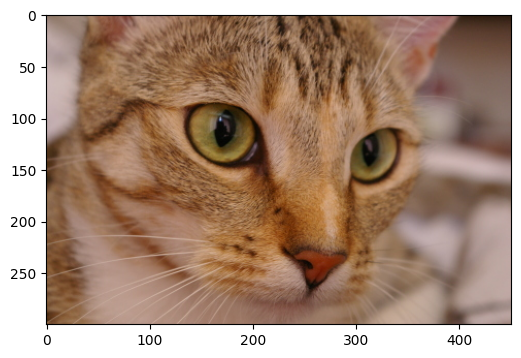


# Prediction (Top 5):
Egyptian_cat : 0.72
tiger_cat    : 0.04
tabby        : 0.03
crossword_puzzle : 0.01
panpipe      : 0.00


In [ ]:
img = keras.applications.imagenet_utils.preprocess_input(
    chelsea(), mode="torch"
)  # Chelsea the cat
img = ops.image.resize(img, (224, 224))[None,]  # resize & create batch
pred = model(img)
pred_dec = keras.applications.imagenet_utils.decode_predictions(pred)[0]

print("\n# Image:")
print(img.shape)
plt.figure(figsize=(6, 6))
plt.imshow(chelsea())
plt.show()
print()

print("# Prediction (Top 5):")
for i in range(5):
    print("{:<12} : {:0.2f}".format(pred_dec[i][1], pred_dec[i][2]))

# Fine-tune **GCViT** Model



In [ ]:
# Model
IMAGE_SIZE = (224, 224)

# Hyper Params
BATCH_SIZE = 32
EPOCHS = 10

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# Other constants
MEAN = 255 * np.array([0.485, 0.456, 0.406], dtype="float32")  # imagenet mean
STD = 255 * np.array([0.229, 0.224, 0.225], dtype="float32")  # imagenet std
AUTO = tf.data.AUTOTUNE

## Data Loader

In [ ]:

def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        # for training, do augmentation
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD  # normalization
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE).prefetch(AUTO)


### Flower Dataset

In [ ]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=False,  # gcs_path is necessary for tpu,
)
num_train = tf.data.experimental.cardinality(train_dataset)
print(int(num_train))
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)


3303


In [ ]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

### Re-Build Model for Flower Dataset

In [ ]:
# Re-Build Model
model = GCViT(**config, num_classes=5)
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))
out = model(inp)

# Load Weights
ckpt_path = keras.utils.get_file(ckpt_link.split("/")[-1], ckpt_link)
model.load_weights(ckpt_path, skip_mismatch=True)
EPOCHS = 10
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
optimizer = keras.optimizers.SGD(scheduled_lrs)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:293: UserWarning: A total of 1 objects could not be loaded. Example error message for object <Dense name=head, built=True>:

Layer 'head' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=head, built=True>]
  warnings.warn(msg)


### Training

In [ ]:
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=EPOCHS, verbose=1
)

Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 114s 694ms/step - accuracy: 0.5533 - loss: 1.0923 - val_accuracy: 0.7629 - val_loss: 0.5914
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 278ms/step - accuracy: 0.7609 - loss: 0.6139 - val_accuracy: 0.2670 - val_loss: 1.5621
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 294ms/step - accuracy: 0.2700 - loss: 1.5750 - val_accuracy: 0.2480 - val_loss: 1.6269
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 272ms/step - accuracy: 0.2789 - loss: 1.5465 - val_accuracy: 0.3351 - val_loss: 1.5079
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 277ms/step - accuracy: 0.2930 - loss: 1.5523 - val_accuracy: 0.1907 - val_loss: 1.6365
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 277ms/step - accuracy: 0.3101 - loss: 1.5484 - val_accuracy: 0.3433 - val_loss: 1.4933
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 274ms/step - accuracy: 0.3590 - loss: 1.4607 - val_accuracy: 0.4033 - val_loss: 1.4088
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 30s 288ms/step - accuracy: 0.4062 - loss: 

<Axes: xlabel='epoch', ylabel='score'>

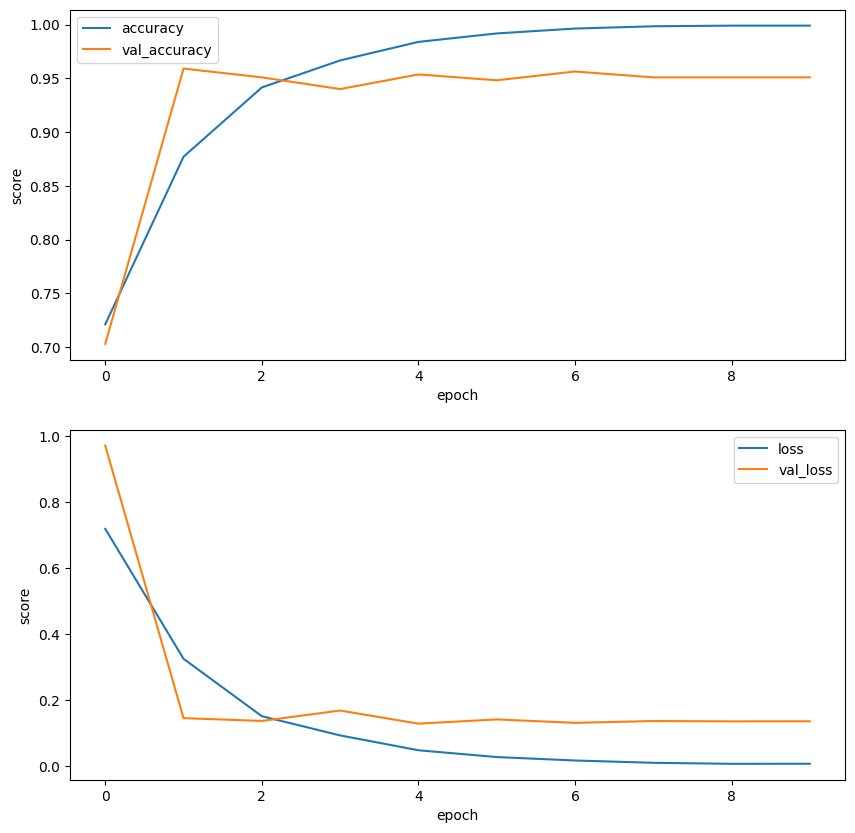

In [ ]:
import pandas as pd
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])


In [ ]:
all_predictions = []
true_batch_labels=[]

i=0

# Iterate over the validation dataset
for batch_images, batch_labels in val_dataset:
    if i==0: print(batch_labels)
    # Make predictions on the current batch
    batch_predictions = model.predict(batch_images).argmax(axis=-1)
    if i==0: print(batch_predictions)
    i+=1
    # Append the predictions to the list
    all_predictions.append(batch_predictions)
    true_batch_labels.append(batch_labels)

# Concatenate predictions from all batches into a single array
all_predictions = np.concatenate(all_predictions, axis=0)
#true_batch_labels=np.array(true_batch_labels)
true_batch_labels=np.concatenate(true_batch_labels, axis=0)
print(true_batch_labels)

tf.Tensor([4 0 0 2 0 0 2 1 3 0 0 0 3 4 0 3 2 0 2 4 2 0 2 0 1 3 1 4 4 3 0 4], shape=(32,), dtype=int64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
[4 0 0 2 0 0 2 1 3 0 0 0 3 2 0 3 2 0 2 4 2 0 4 0 1 3 1 2 4 3 0 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
[4 0 0 2 0 0 2 1 3 0 0 0 3 4 0 3 2 0 2 4 2 0 2 0 1 3 1 4 4 3 0 4 4 4 2 1 4
 0 1 3 4 3 3 4 1 1 0 0 4 2 4 0 4 1 1 2 4 2 1 2 4 3 3 1 0 1 3 2 3 3 2 2 4 2
 0 3 1 2 4 0 4 4 1 4 0 3 2 2 4 1 2 0 1 1 3 3 3 3 4 4 3 2 4 4 2 0 3 4 2 1 2
 4 2 1 4 0 4 0 1 2 2 1 4 2 2 2 3 0 3 3 0 4 4 1 3 3 2 1 2 4 3 1 3 2 1 4 3 0
 3 2 2 4 4 0 0 3 2 3 4 4 2 4 4 1 1 3 4 2 3 1 0 4 4 4 4 2 4 1 0 3 2 4 3 2 4

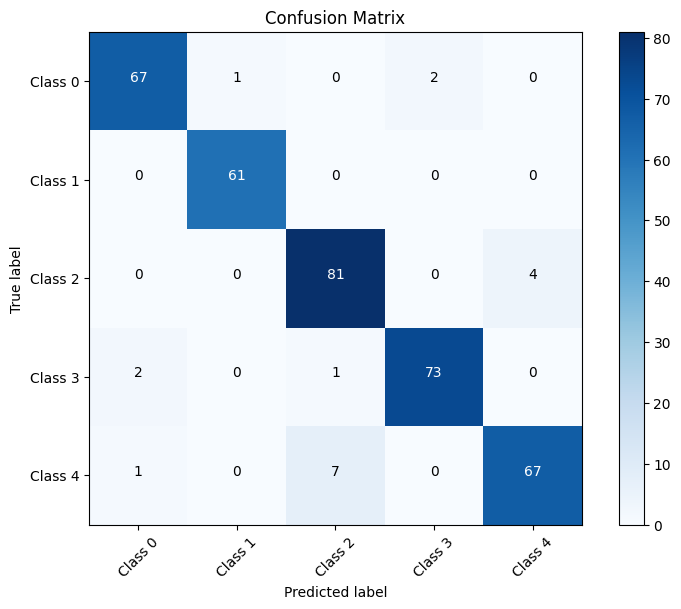

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Assuming predictions are already computed
#true_labels = np.argmax(sample_labels, axis=-1)
#print(true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_batch_labels, all_predictions)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = [f'Class {i}' for i in range(conf_matrix.shape[0])]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
sample_images, sample_labels = next(iter(val_dataset))
print(sample_labels.shape)

predictions = model.predict(sample_images , batch_size=100).argmax(axis=-1)
evaluations = model.evaluate(sample_images, sample_labels, batch_size=100)

print("[val_loss, val_acc]", evaluations)

(32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9062 - loss: 0.2339
[val_loss, val_acc] [0.23387598991394043, 0.90625]


In [ ]:
print(history)

In [ ]:
model = GCViT(**config, num_classes=5)
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))
out = model(inp)

# Load Weights
ckpt_path = keras.utils.get_file(ckpt_link.split("/")[-1], ckpt_link)
model.load_weights(ckpt_path, skip_mismatch=True)
EPOCHS = 10
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:293: UserWarning: A total of 1 objects could not be loaded. Example error message for object <Dense name=head, built=True>:

Layer 'head' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=head, built=True>]
  warnings.warn(msg)


In [ ]:
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=EPOCHS, verbose=1
)


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 154s 706ms/step - accuracy: 0.6235 - loss: 0.9772 - val_accuracy: 0.8774 - val_loss: 0.3269
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 293ms/step - accuracy: 0.8858 - loss: 0.3211 - val_accuracy: 0.8856 - val_loss: 0.2693
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.9065 - loss: 0.2631 - val_accuracy: 0.6812 - val_loss: 0.8019
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.8246 - loss: 0.4812 - val_accuracy: 0.9101 - val_loss: 0.2615
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - accuracy: 0.9173 - loss: 0.2286 - val_accuracy: 0.8529 - val_loss: 0.4463
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.9405 - loss: 0.1512 - val_accuracy: 0.9237 - val_loss: 0.1837
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.9600 - loss: 0.1236 - val_accuracy: 0.9128 - val_loss: 0.2679
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.9594 - loss: 

<Axes: xlabel='epoch', ylabel='score'>

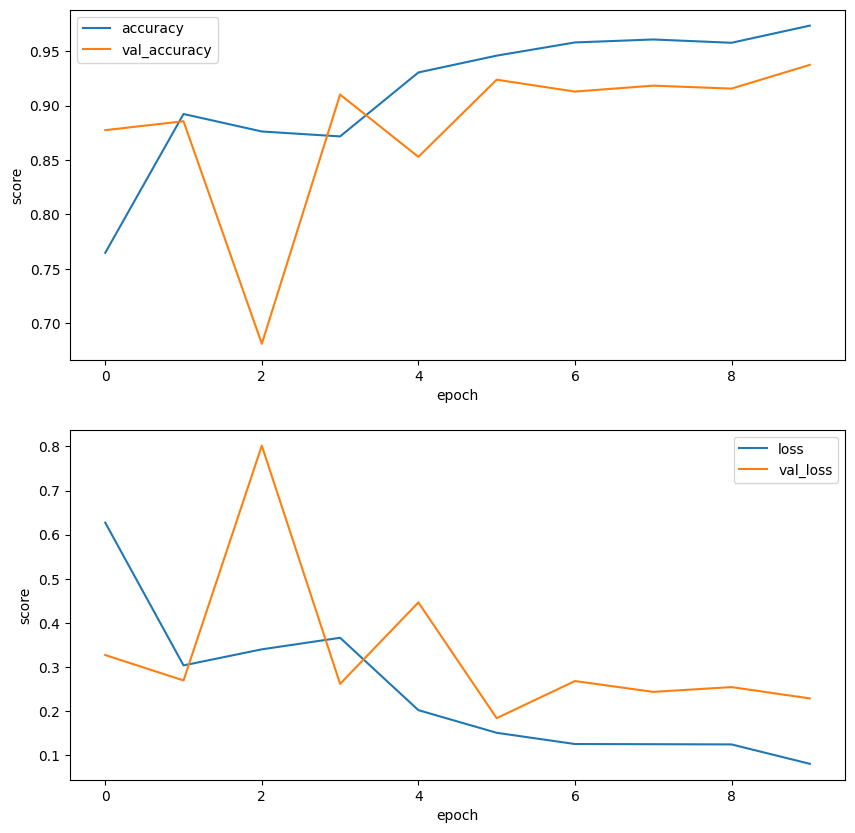

In [ ]:
import pandas as pd
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])


In [ ]:
all_predictions = []
true_batch_labels=[]

i=0

# Iterate over the validation dataset
for batch_images, batch_labels in val_dataset:
    if i==0: print(batch_labels)
    # Make predictions on the current batch
    batch_predictions = model.predict(batch_images).argmax(axis=-1)
    if i==0: print(batch_predictions)
    i+=1
    # Append the predictions to the list
    all_predictions.append(batch_predictions)
    true_batch_labels.append(batch_labels)

# Concatenate predictions from all batches into a single array
all_predictions = np.concatenate(all_predictions, axis=0)
#true_batch_labels=np.array(true_batch_labels)
true_batch_labels=np.concatenate(true_batch_labels, axis=0)
print(true_batch_labels)

tf.Tensor([4 0 0 2 0 0 2 1 3 0 0 0 3 4 0 3 2 0 2 4 2 0 2 0 1 3 1 4 4 3 0 4], shape=(32,), dtype=int64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
[2 0 0 2 0 0 2 1 3 0 0 0 3 2 0 3 2 0 1 4 2 0 2 0 1 3 1 2 4 3 0 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
[4 0 0 2 0 0 2 1 3 0 0 0 3 4 0 3 2 0 2 4 2 0 2 0 1 3 1 4 4 3 0 4 4 4 2 1 4
 0 1 3 4 3 3 4 1 1 0 0 4 2 4 0 4 1 1 2 4 2 1 2 4 3 3 1 0 1 3 2 3 3 2 2 4 2
 0 3 1 2 4 0 4 4 1 4 0 3 2 2 4 1 2 0 1 1 3 3 3 3 4 4 3 2 4 4 2 0 3 4 2 1 2
 4 2 1 4 0 4 0 1 2 2 1 4 2 2 2 3 0 3 3 0 4 4 1 3 3 2 1 2 4 3 1 3 2 1 4 3 0
 3 2 2 4 4 0 0 3 2 3 4 4 2 4 4 1 1 3 4 2 3 1 0 4 4 4 4 2 4 1 0 3 2 4 3 2 4
 4 1

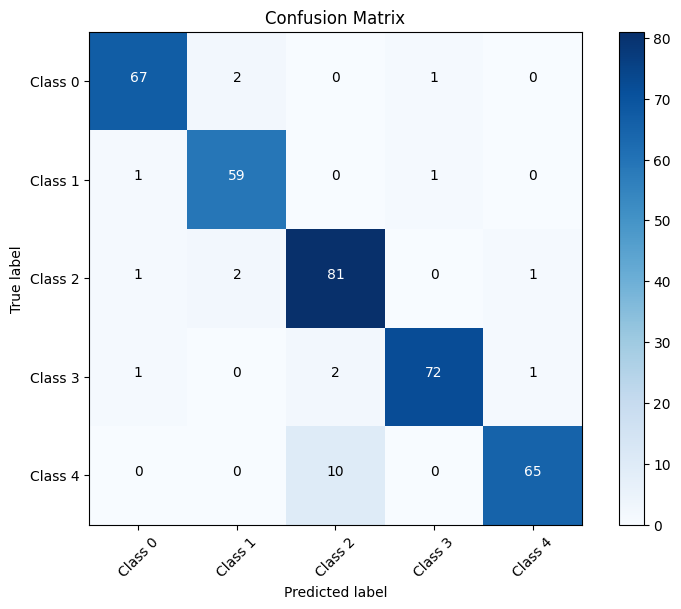

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Assuming predictions are already computed
#true_labels = np.argmax(sample_labels, axis=-1)
#print(true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_batch_labels, all_predictions)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = [f'Class {i}' for i in range(conf_matrix.shape[0])]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
sample_images, sample_labels = next(iter(val_dataset))
print(sample_labels.shape)

predictions = model.predict(sample_images , batch_size=100).argmax(axis=-1)
evaluations = model.evaluate(sample_images, sample_labels, batch_size=100)

print("[val_loss, val_acc]", evaluations)

(32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8750 - loss: 0.3202
[val_loss, val_acc] [0.3202003240585327, 0.875]


Batch shape: (5, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predictions shape: (5, 5)
Predicted classes: ['dandelion', 'sunflowers', 'tulips', 'daisy', 'roses']

# Images:


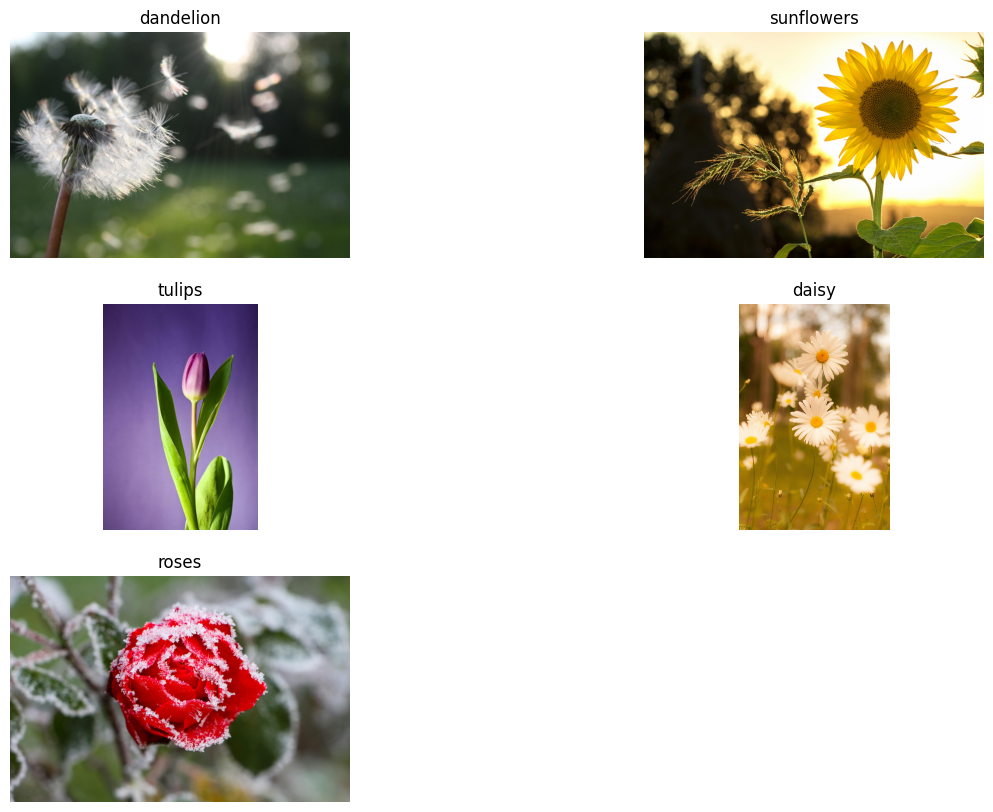

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
from PIL import Image

# Load your own images
image_paths = [
    "/content/pexels-nita-9825-54300 (1).jpg",
    "/content/pexels-pixabay-33044.jpg",
    "/content/pexels-pixabay-36729.jpg",
    "/content/pexels-xuan-hoa-le-12135-61379.jpg",
    "/content/pexels-landsmann-803094805-19161936.jpg"
]

# Load and preprocess the images
images = []
for path in image_paths:
    image = Image.open(path)
    img = keras.applications.imagenet_utils.preprocess_input(np.array(image), mode="torch")
    img = tf.image.resize(img, (224, 224))  # Resize
    images.append(img)

# Stack the images to create a batch
batch = np.stack(images, axis=0)
print("Batch shape:", batch.shape)

# Generate predictions using the model
preds = model.predict(batch)
print("Predictions shape:", preds.shape)

# Decode predictions to human-readable labels
predicted_classes = np.argmax(preds, axis=1)
pred_dec = [CLASSES[i] for i in predicted_classes]

print("Predicted classes:", pred_dec)

# Display the original images
print("\n# Images:")
plt.figure(figsize=(15, 10))
for i, image_path in enumerate(image_paths):
    plt.subplot(3, 2, i + 1)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(pred_dec[i])
    plt.axis('off')
plt.show()
